In [97]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import matplotlib.animation as animation
import networkx as nx
import rider

import time
import ipdb
from IPython import display

%matplotlib inline

地图可以看成一个weighted graph

In [2]:
nodes = pd.read_csv('./data/node.csv')
edges = pd.read_csv('./data/edge.csv')

edges['distance'] = ''
for i in edges.index:
    from_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'from']]
    to_node = nodes.loc[nodes['NodeName']==edges.loc[i, 'to']]
    edges.loc[i, 'distance'] = np.sqrt(
        (from_node['x'].values[0] - to_node['x'].values[0])**2 + (from_node['y'].values[0] - to_node['y'].values[0])**2
    )

    

In [3]:
G = nx.Graph()
G.add_nodes_from(nodes['NodeName'])
G.add_weighted_edges_from(edges.iloc[:, 1:].to_numpy())

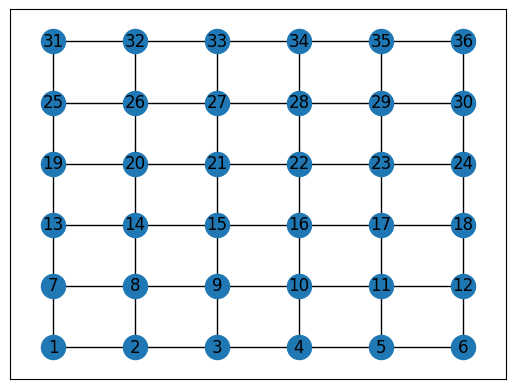

In [4]:
pos = dict(zip(nodes['NodeName'].to_numpy(), nodes[['x', 'y']].to_numpy()))
nx.draw_networkx(G, pos=pos)

In [5]:
nx.dijkstra_path(G, 1, 15)

[1, 2, 3, 9, 15]

In [6]:
class platform:
    def __init__(self, r, cR, k, t_resolution):
        self.accumulated_order = []
        self.r = r
        self.cR = cR
        self.k = k
        self.t_resolution = t_resolution
    
    def acquire_order(self, q):
        q_t_resolution = q * self.t_resolution
        num_generated_order = np.random.randint(2 * q_t_resolution)
        self.accumulated_order.extend(list(np.random.randint(1, 36, size=num_generated_order)))
    
    def remove_order(self, matched_batches):
        for i in matched_batches.flatten():
            self.accumulated_order.remove(i)
    
    def match(self, idle_rider_IDs):
        n_idle_riders = len(idle_rider_IDs)
        p = 1 - np.exp(-np.pi*r**2* n_idle_riders / A_c)
        n_orders = len(self.accumulated_order)
        n_batches = n_orders / self.k

        pp = min(p * n_batches / n_idle_riders, 1)
        pp = 0 if np.isnan(pp) else pp

        matched_rider_IDs = np.random.choice(idle_rider_IDs, int(n_idle_riders*pp) )
        
        matched_batches = []
        for i in range(len(matched_rider_IDs)):
            matched_batches.append(np.array(self.accumulated_order)[self.k*i:self.k*(i+1)])
        matched_batches = np.array(matched_batches)
        
        self.remove_order(matched_batches)
        
        self.matched_batches = matched_batches

        return matched_batches, list(matched_rider_IDs), p, pp
        

In [49]:
import multiprocessing
from multiprocessing import Pool

def move_all_riders(N, matched_rider_IDs, matched_batches):
    n_cpu = multiprocessing.cpu_count()
    pool = Pool(processes=n_cpu)
    
    # number of riders at each process
    N_each_process = N // (n_cpu - 1) if N%n_cpu != 0 else N // n_cpu
    n_process = n_cpu if N%N_each_process != 0 else n_cpu - 1
    
    params = []
    for i in range(n_process):
        params.append(
            [
                rider_set[i*N_each_process:(i+1)*N_each_process],
                knowledge_set[i*N_each_process:(i+1)*N_each_process],
                t_resolution,
                matched_rider_IDs,
                matched_batches
            ]
        )

    moved_rider_set = pool.starmap(func=rider.move_rider, iterable=params )
    return moved_rider_set

In [109]:
config_set = []
rider_set = []
knowledge_set = []
N = 200
q_bar = 500
r = 2
cR = 8
k = 3
t_resolution = 0.005

A_c = 36

for i in range(N):
    config_i = {
        'ID': i,
        'initial_position': np.array([np.random.randint(25), np.random.randint(25)]),
        'maxspeed': np.random.randint(50, 70)
    }
    rider_i = rider.rider(config_i)

    knowledge_i = {
        'map': G,
        'merchant_node': 15,
        'customer_nodes': []
    }
    
    config_set.append(config_i)
    rider_set.append(rider_i)
    knowledge_set.append(knowledge_i)
    
plat = platform(r, cR, k, t_resolution)

In [110]:
c = 0
x_axis = []
num_idle_rider_IDs_set = []
num_accumulated_order_set = []
p_set = []
pp_set = []

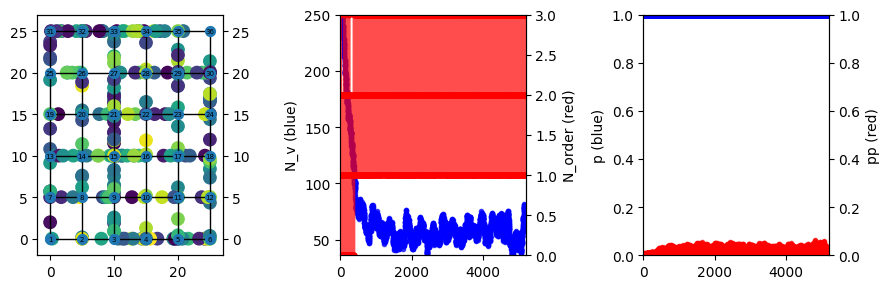

rider 187 completed!


KeyboardInterrupt: 

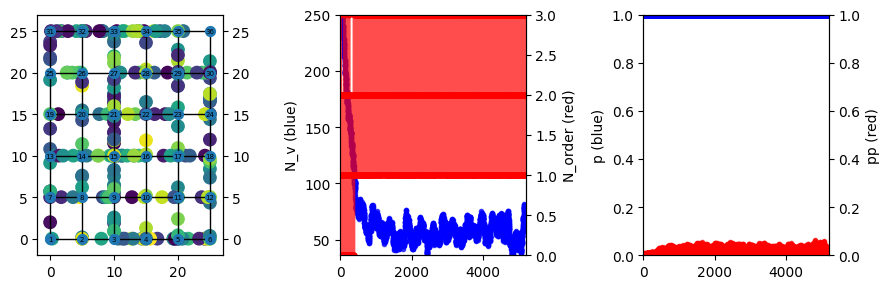

In [111]:
color = np.random.rand(N)

# marking the x-axis and y-axis
fig = plt.figure(figsize=[9, 3])
ax = fig.add_subplot(131)
ax0 = ax.twinx()
ax.set_xlim(-2, 27)
ax.set_ylim(-2, 27)
ax0.set_xlim(-2, 27)
ax0.set_ylim(-2, 27)

ax2 = fig.add_subplot(132)
ax2.set_ylabel('N_v (blue)')

ax3 = ax2.twinx()
ax3.set_ylabel('N_order (red)')

ax4 = fig.add_subplot(133)
ax4.set_ylabel('p (blue)')
ax4.set_ylim([0, 1])

ax5 = ax4.twinx()
ax5.set_ylabel('pp (red)')
ax5.set_ylim([0, 1])

plt.tight_layout()

nx.draw_networkx(G, pos=pos, ax=ax0, node_size=50, font_size=5)


scat = ax.scatter([], [], s=80)
line2, = ax2.plot([], [], 'b.-', alpha=0.7)
line3, = ax3.plot([], [], 'r.-', alpha=0.7)
line4, = ax4.plot([], [], 'b.-', alpha=0.7)
line5, = ax5.plot([], [], 'r.-', alpha=0.7)

while c < 100000:
    idle_rider_IDs = []
    for i in range(N):
        if rider_set[i].state=='idle':
            idle_rider_IDs.append(rider_set[i].ID)
    
    plat.acquire_order(q_bar)
    matched_batches, matched_rider_IDs, p, pp = plat.match(idle_rider_IDs)
    
    
    # move
    rider_set = rider.move_rider(rider_set, knowledge_set, t_resolution, matched_rider_IDs, matched_batches)
#     moved_rider_set = move_all_riders(N, matched_rider_IDs, matched_batches)
#     moved_rider_set = [item for sublist in moved_rider_set for item in sublist]
#     rider_set = moved_rider_set
    
    moved_rider_set, num_idle_rider_IDs, num_accumulated_order, p, pp = animate(i, rider_set)
    
    t1 = time.time()
    x_axis.append(c)
    num_idle_rider_IDs_set.append(len(idle_rider_IDs))
    num_accumulated_order_set.append(len(plat.accumulated_order))
    p_set.append(p)
    pp_set.append(pp)
    
    if c%10==0:
        scat.set_offsets(
            np.array( [ [rider_set[i].position[0], rider_set[i].position[1]] for i in range(N)] )
        )
        scat.set_array(color)
        line2.set_data(x_axis, num_idle_rider_IDs_set)
        ax2.set_ylim([min(num_idle_rider_IDs_set), N])
        line3.set_data(x_axis, num_accumulated_order_set)
        ax3.set_ylim([0, max(num_accumulated_order_set)])
        line4.set_data(x_axis, p_set)
        ax4.set_ylim([0, 1])
        line5.set_data(x_axis, pp_set)
        ax5.set_ylim([0, 1])

        ax2.set_xlim([0, c])
        ax3.set_xlim([0, c])
        ax4.set_xlim([0, c])
        ax5.set_xlim([0, c])

        display.clear_output(wait=True)
        display.display(plt.gcf()) 

    c += 1
    

In [22]:
for i in range(N):
    print(rider_set[i].ID, rider_set[i].position)

0 [10.         15.64934802]
1 [5.         8.69645924]
2 [24.17136683 25.        ]
3 [ 3.47769221 15.        ]
4 [20.         22.90905518]
5 [18.37539597  0.        ]
6 [15 10]
7 [10.          5.90061977]
8 [5.         7.31909934]
9 [20.         1.3894055]
10 [20.         22.60959704]
11 [10.        18.2659852]
12 [12.73559851 20.        ]
13 [ 7.11139971 20.        ]
14 [15.          3.67019421]
15 [ 7.28906527 10.        ]
16 [18.9039952  5.       ]
17 [5.         1.11019242]
18 [8.58001715 0.        ]
19 [25.         10.44306518]
20 [25.         11.72165661]
21 [ 9.38994858 20.        ]
22 [15.         8.1027698]
23 [20.        22.3003865]
24 [5.        1.1735064]
25 [ 5.         16.84813176]
26 [0.         4.69305258]
27 [10.         13.71462485]
28 [18.1060652  0.       ]
29 [13.4263047 20.       ]
30 [11.225  0.   ]
31 [ 7.44977178 10.        ]
32 [15.         10.60960412]
33 [20.         17.38274527]
34 [ 6.24306711 25.        ]
35 [10.         19.42163854]
36 [5.73 0.  ]
37 [10 